In [1]:
!pip install --upgrade "opinionated" "seaborn" "dask[dataframe]" "matplotlib"

In [2]:
import dask.dataframe as dd
import seaborn as sns
import pandas as pd
import opinionated  # noqa
import matplotlib.pyplot as plt
plt.style.use("opinionated_rc")

software_mentions = dd.read_parquet("nsf-soft-search-pub-dois/successful-results/*.parquet").compute()
errors = dd.read_parquet("nsf-soft-search-pub-dois/failed-results/*.parquet").compute()

Now downloading: Roboto Condensed
Added new font as Roboto Condensed Light
Added new font as Roboto Condensed
Added new font as Roboto Condensed
Added new font as Roboto Condensed Black
Now downloading: Montserrat
Added new font as Montserrat Thin Light
Added new font as Montserrat Thin
Added new font as Montserrat Thin
Added new font as Montserrat Thin Black
Now downloading: Source Code Pro
Added new font as Source Code Pro ExtraLight Light
Added new font as Source Code Pro ExtraLight
Added new font as Source Code Pro ExtraLight
Added new font as Source Code Pro ExtraLight Black
Now downloading: Fira Sans
Added new font as Fira Sans Light
Added new font as Fira Sans
Added new font as Fira Sans
Added new font as Fira Sans Black
Now downloading: Fira Sans Condensed
Added new font as Fira Sans Condensed Light
Added new font as Fira Sans Condensed
Added new font as Fira Sans Condensed
Added new font as Fira Sans Condensed Black
Now downloading: IBM Plex Sans
Added new font as IBM Plex San

## Number of Software Mentions per Paper

<Axes: xlabel='count'>

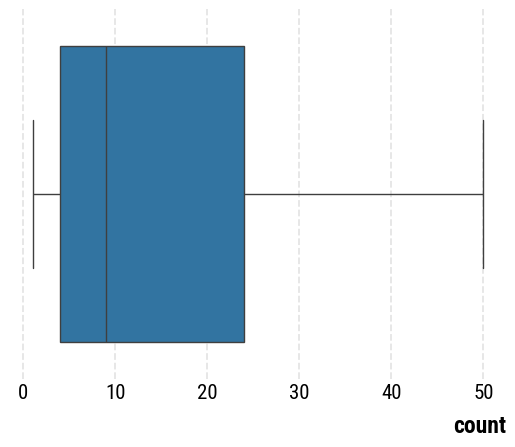

In [3]:
mentions_per_paper = software_mentions.doi.value_counts().to_frame().reset_index()
sns.boxplot(mentions_per_paper, x="count", showfliers=False)

## Distribution of Mention Intent

GROBID Software Mentions model and CZI Soft Cite model produce roughly the same results for how software is mentioned.

<Axes: xlabel='grobid_intent_cls', ylabel='count'>

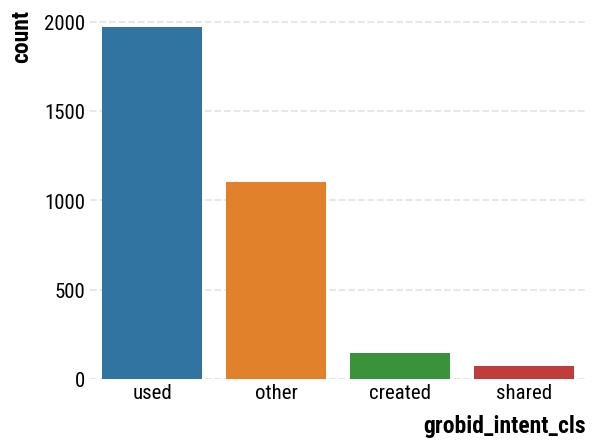

In [4]:
grobid_intents = software_mentions.grobid_intent_cls.value_counts().to_frame().reset_index()
soft_cite_intents = software_mentions.czi_soft_cite_intent_cls.value_counts().to_frame().reset_index()

sns.barplot(
    grobid_intents,
    y="count",
    x="grobid_intent_cls",
    hue="grobid_intent_cls",
)

<Axes: xlabel='czi_soft_cite_intent_cls', ylabel='count'>

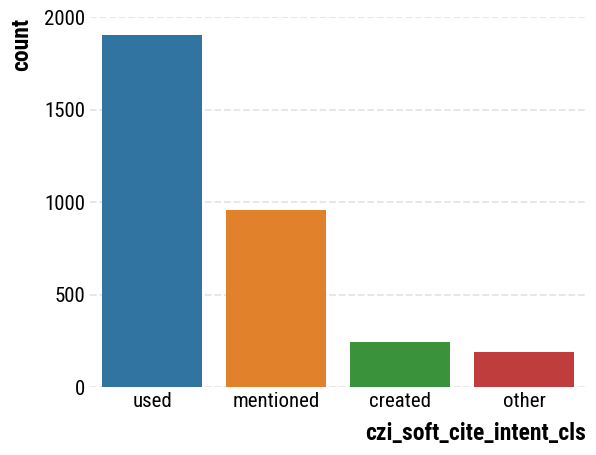

In [5]:
sns.barplot(
    soft_cite_intents,
    y="count",
    x="czi_soft_cite_intent_cls",
    hue="czi_soft_cite_intent_cls",
)

## Created Software

In [6]:
created_software = software_mentions.loc[
    (software_mentions.grobid_intent_cls == "created") |
    (software_mentions.czi_soft_cite_intent_cls == "created")
]

# Log how many of these rows have different intent cls and then print a sample of the contexts
diff = created_software.loc[
    created_software.grobid_intent_cls != created_software.czi_soft_cite_intent_cls
]
print(
    f"Different Classifications between GROBID and CZI Soft Cite: "
    f"{len(diff)} ({round((len(diff) / len(created_software) * 100), 3)}%)"
)
print()
print("Examples:")
print("-" * 80)
for _, row in diff.sample(5, random_state=12).iterrows():
    print(f"Software: '{row.software_name_raw}'")
    print(f"Context: '{row.context}'")
    print(f"GROBID: '{row.grobid_intent_cls}'")
    print(f"CZI Soft Cite: '{row.czi_soft_cite_intent_cls}'")
    print()

Different Classifications between GROBID and CZI Soft Cite: 199 (67.23%)

Examples:
--------------------------------------------------------------------------------
Software: 'JCVI'
Context: 'All predicted structure models, functions, and interactions are available at our public Webserver at https:// zhanglab.ccmb.med.umich.edu/JCVI-syn3.0/,'
GROBID: 'shared'
CZI Soft Cite: 'created'

Software: 'HAPiID'
Context: 'Availability of data and materials The HAPiID pipeline and all of the required data for running the pipeline are available for download at https://github.com/mgtools/HAPiID.'
GROBID: 'shared'
CZI Soft Cite: 'created'

Software: 'BLAST'
Context: 'The basic design of GriffinDetector is to classify BLAST alignment hits of a query gene from a focus species (the species where we want to detect fusion genes) to several species into 2 groups, the long homologous gene group, i.e., potential fusion genes (e.g., two exons structure in Fig. 1 below the in-group), and the short homologous

### Notes

Generally it seems like we want to use the GROBID predicted labels to get direct links to code and to find all possible "created software." This is because the GROBID labels predict if the specific software entity found was shared, created, used, or other, while the soft cite model takes the whole sentence and doesn't focus on the specificity to the entity.

For example, in the "BLAST", I think CZI Soft Cite gets the overall label correct (the authors are describing created software [GriffinDetector]) however GROBID also gets BLAST correct because it is not the entity of the sentence. The sample below expands on this to show that GROBID marked "GriffinDetector" as created AND shared in other parts of the document.

In [7]:
created_software.loc[
    created_software.software_name_raw == "GriffinDetector"
][[
    "context",
    "software_name_raw",
    "grobid_intent_cls",
    "czi_soft_cite_intent_cls",
]]

,context,software_name_raw,grobid_intent_cls,czi_soft_cite_intent_cls
10,GriffinDetector is available at http://longlab...,GriffinDetector,shared,created
18,"First, GriffinDetector is the first pipeline t...",GriffinDetector,created,mentioned
21,"Our pipeline, GriffinDetector, de- tects fusio...",GriffinDetector,created,created
24,The basic design of GriffinDetector is to clas...,GriffinDetector,other,created
29,"Lastly, our results show that GriffinDetector ...",GriffinDetector,created,mentioned
31,"Here, we presented a new pipeline, GriffinDete...",GriffinDetector,created,created
43,"Here we report a computational search method, ...",GriffinDetector,created,created


## Papers Creating Software

Out of all of the papers which were fully successfully processed, we predict that 21.4% created software (tools, analysis scripts, algorithms, etc.). We further predict that 18.6% of them shared a link to the software they created. 

In [8]:
grobid_created = software_mentions.loc[software_mentions.grobid_intent_cls == "created"]
software_creation_rate = round((grobid_created.doi.nunique() / software_mentions.doi.nunique()) * 100, 3)

grobid_shared = software_mentions.loc[software_mentions.grobid_intent_cls == "shared"]
software_shared_rate = round((grobid_shared.doi.nunique() / software_mentions.doi.nunique()) * 100, 3)

print(f"Software Creation Rate: {software_creation_rate}%")
print(f"Software Shared Rate: {software_shared_rate}%")

Software Creation Rate: 21.379%
Software Shared Rate: 18.621%


## Grants Creating Software

Out of the sample of grants which had papers successfully processed, we predict that 24.6% created software (tools, analysis scripts, algorithms, etc.). We oddly predict that 28.9% of them shared a link to the software they created. This figure being higher than the creation rate is possibly due to the fact that GROBID may have only detected software sharing in some of the papers but did not detect specifically named software created. For example, it is likely that some papers (and in turn grants) only created analysis scripts. Analysis scripts rarely have a name and thus GROBID might detect ONLY the sharing of a link to analysis scripts and not the creation of them.

In [9]:
# Read in the grant publications data
grant_publications = pd.read_parquet("grant-publications.parquet")

# Merge software mentions with grant publications on doi
merged = software_mentions.merge(grant_publications, on="doi", how="left")

# Get creation rates
grants_grobid_created = merged.loc[merged.grobid_intent_cls == "created"]
grant_software_creation_rate = round((grants_grobid_created["id"].nunique() / merged["id"].nunique()) * 100, 3)

grants_grobid_shared = merged.loc[merged.grobid_intent_cls == "shared"]
grant_software_shared_rate = round((grants_grobid_shared["id"].nunique() / merged["id"].nunique()) * 100, 3)

print(f"Grant Software Creation Rate: {grant_software_creation_rate}%")
print(f"Grant Software Shared Rate: {grant_software_shared_rate}%")

Grant Software Creation Rate: 24.561%
Grant Software Shared Rate: 28.947%


## Errors

The largest source of "errors" is simply not finding open access PDFs or Downloading PDFs.

I don't think we can improve the rate at finding open access PDF URLs, we may be able to improve our PDF downloading as most of the issues come from URLs rerouting to "verified" sources. I.e. I think switching from requests to selenium might work but I also don't think we _need_ it.

<Axes: xlabel='step', ylabel='count'>

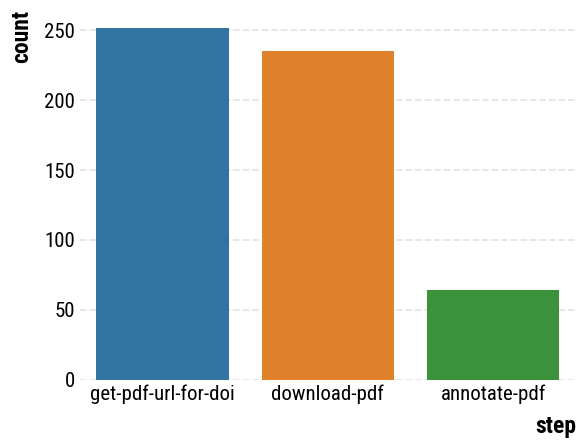

In [10]:
sns.barplot(
    errors.step.value_counts().to_frame().reset_index(),
    x="step",
    y="count",
    hue="step",
)

Error rate: 62.821%


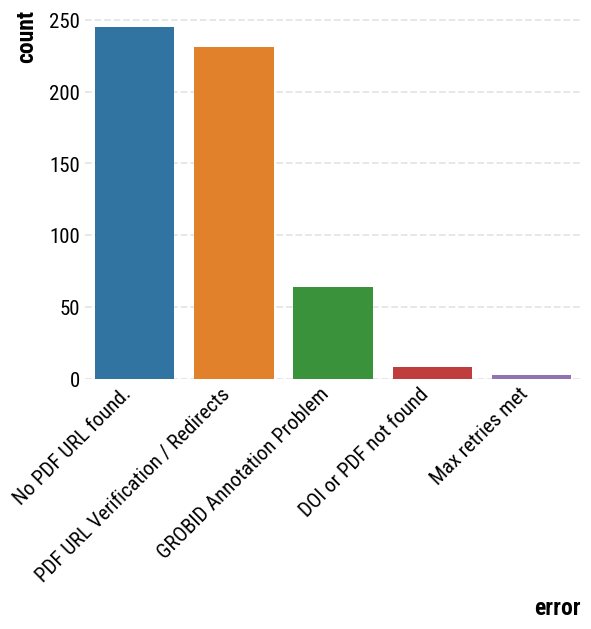

In [11]:
# Making errors simpler to handle
errors.loc[errors.error.str.contains("403 Client Error")] = "PDF URL Verification / Redirects"
errors.loc[errors.error.str.contains("No such file")] = "GROBID Annotation Problem"
errors.loc[errors.error.str.contains("context")] = "GROBID Annotation Problem"
errors.loc[errors.error.str.contains("Client Error: NOT FOUND")] = "DOI or PDF not found"
errors.loc[errors.error.str.contains("Max retries exceeded")] = "Max retries met"

unique_dois_successful = software_mentions.doi.nunique()
unique_dois_failed = errors.doi.nunique()
error_rate = round((unique_dois_failed / (unique_dois_successful + unique_dois_failed)) * 100, 3)

print(f"Error rate: {error_rate}%")

sns.barplot(
    errors.error.value_counts().to_frame().reset_index(),
    x="error",
    y="count",
    hue="error",
)
_ = plt.xticks(rotation=45, ha="right")